# Transfer learning :
Transfer learning is a machine learning method where a model trained on one task is reused as the starting point for a new, related task
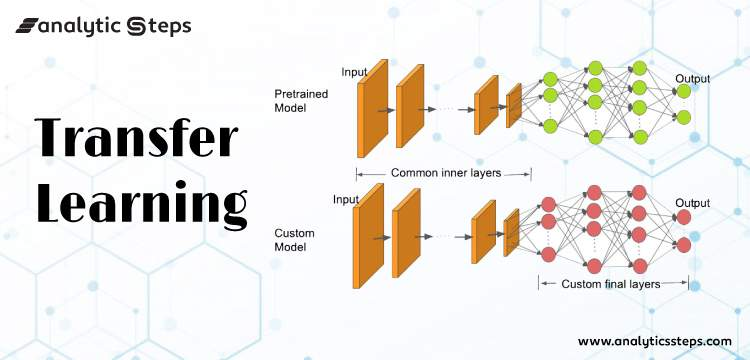

In [15]:
!pip install opendatasets --upgrade --quiet

In [16]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/tanlikesmath/the-oxfordiiit-pet-dataset'
od.download(dataset_url)


Dataset URL: https://www.kaggle.com/datasets/tanlikesmath/the-oxfordiiit-pet-dataset


100%|██████████| 1.48G/1.48G [00:18<00:00, 85.7MB/s]


In [17]:
import tarfile

with tarfile.open('./the-oxfordiiit-pet-dataset.tgz', 'r:gz') as tar:
    tar.extractall(path='./the-oxfordiiit-pet-dataset')

FileNotFoundError: [Errno 2] No such file or directory: './the-oxfordiiit-pet-dataset.tgz'

In [18]:
from torch.utils.data import Dataset

In [19]:
import os

DATA_DIR ='./the-oxfordiiit-pet-dataset/images'

file=os.listdir(DATA_DIR)
file[:5]

['pomeranian_168.jpg',
 'Siamese_24.jpg',
 'miniature_pinscher_13.jpg',
 'saint_bernard_47.jpg',
 'Bombay_69.jpg']

In [20]:
def parse_breed(fname):
  parts=fname.split('_')
  return ' '.join(parts[:-1])


In [21]:
parse_breed(file[4])

'Bombay'

In [22]:
from PIL import Image

def open_image(path):
  with open(path, 'rb') as f:
    img = Image.open(f)
    return img.convert('RGB')

(np.float64(-0.5), np.float64(299.5), np.float64(224.5), np.float64(-0.5))

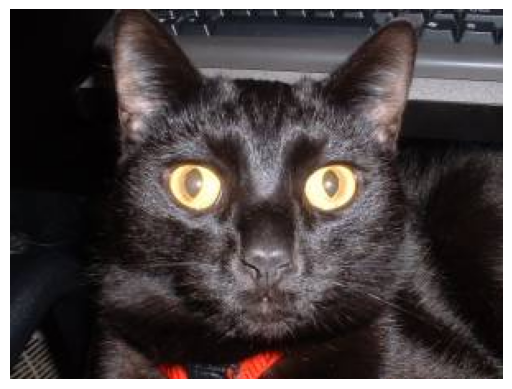

In [23]:
import matplotlib.pyplot as plt

plt.imshow(open_image(os.path.join(DATA_DIR, file[4])))
plt.axis('off')

In [24]:
# creating a custom dataset

import os
from torch.utils.data import Dataset

class PetsDataset(Dataset):
  def __init__(self, root, transform):
    super().__init__()
    self.root =root
    self.files =[fname for fname in os.listdir(root) if fname.endswith('.jpg')]
    self.classes = list(set(parse_breed(fname) for fname in file))
    self.transform = transform

  def __len__(self):
    return len(self.files)

  def __getitem__(self, i):
    fname = self.files[i]
    fpath = os.path.join(self.root, fname)
    img = self.transform(open_image(fpath))
    class_idx = self.classes.index(parse_breed(fname))
    return img, class_idx

In [25]:
import torchvision.transforms as T

img_size=224
imagenet_state = ([0.485,0.456,0.406],[0.229, 0.224, 0.225])
dataset = PetsDataset(DATA_DIR, T.Compose([
    T.Resize(img_size),
    T.Pad(8, padding_mode='reflect'),
    T.RandomCrop(img_size),
    T.ToTensor(),
    T.Normalize(*imagenet_state)
]))

In [26]:
len(dataset)

7390

In [27]:
dataset.classes

['',
 'Bombay',
 'great pyrenees',
 'american pit bull terrier',
 'Birman',
 'newfoundland',
 'British Shorthair',
 'Ragdoll',
 'american bulldog',
 'chihuahua',
 'Bengal',
 'pug',
 'wheaten terrier',
 'japanese chin',
 'havanese',
 'Egyptian Mau',
 'english cocker spaniel',
 'scottish terrier',
 'miniature pinscher',
 'german shorthaired',
 'samoyed',
 'basset hound',
 'leonberger',
 'saint bernard',
 'Sphynx',
 'beagle',
 'Russian Blue',
 'staffordshire bull terrier',
 'boxer',
 'shiba inu',
 'english setter',
 'yorkshire terrier',
 'Maine Coon',
 'Persian',
 'Abyssinian',
 'pomeranian',
 'keeshond',
 'Siamese']

In [28]:
# denormalizing the images

import torch
import matplotlib.pyplot as plt
%matplotlib inline

def denormalize(image, means, stds):
  if len(image.shape)==3:
      image=image.unsqueeze(0)
  means = torch.tensor(means).reshape(1,3,1,1)
  stds = torch.tensor(stds).reshape(1,3,1,1)
  return image * stds + means

def show_image(img_tensor, label):
  print('Lable: ',dataset.classes[label], '(' + str(label)+ ')')
  img_tensor = denormalize(img_tensor, *imagenet_state)[0].permute((1,2,0))
  plt.imshow(img_tensor)
  plt.axis('off')



Lable:  japanese chin (13)


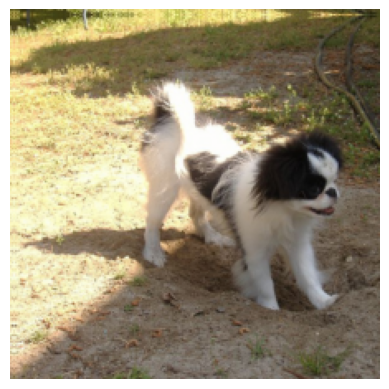

In [29]:
show_image(*dataset[20])

# Creating Training and validation sets

In [30]:
from torch.utils.data import random_split

In [31]:
val_pct=0.1
val_size = int(val_pct * len(dataset))

train_ds, valid_ds = random_split(dataset, [len(dataset)- val_size, val_size])


In [32]:
from torch.utils.data import DataLoader
batch_size = 256

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [33]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(16,16))
    ax.set_xticks([]); ax.set_yticks([])
    images = denormalize(images[:64], *imagenet_state)
    ax.imshow(make_grid(images, nrow=8).permute(1,2,0))
    break

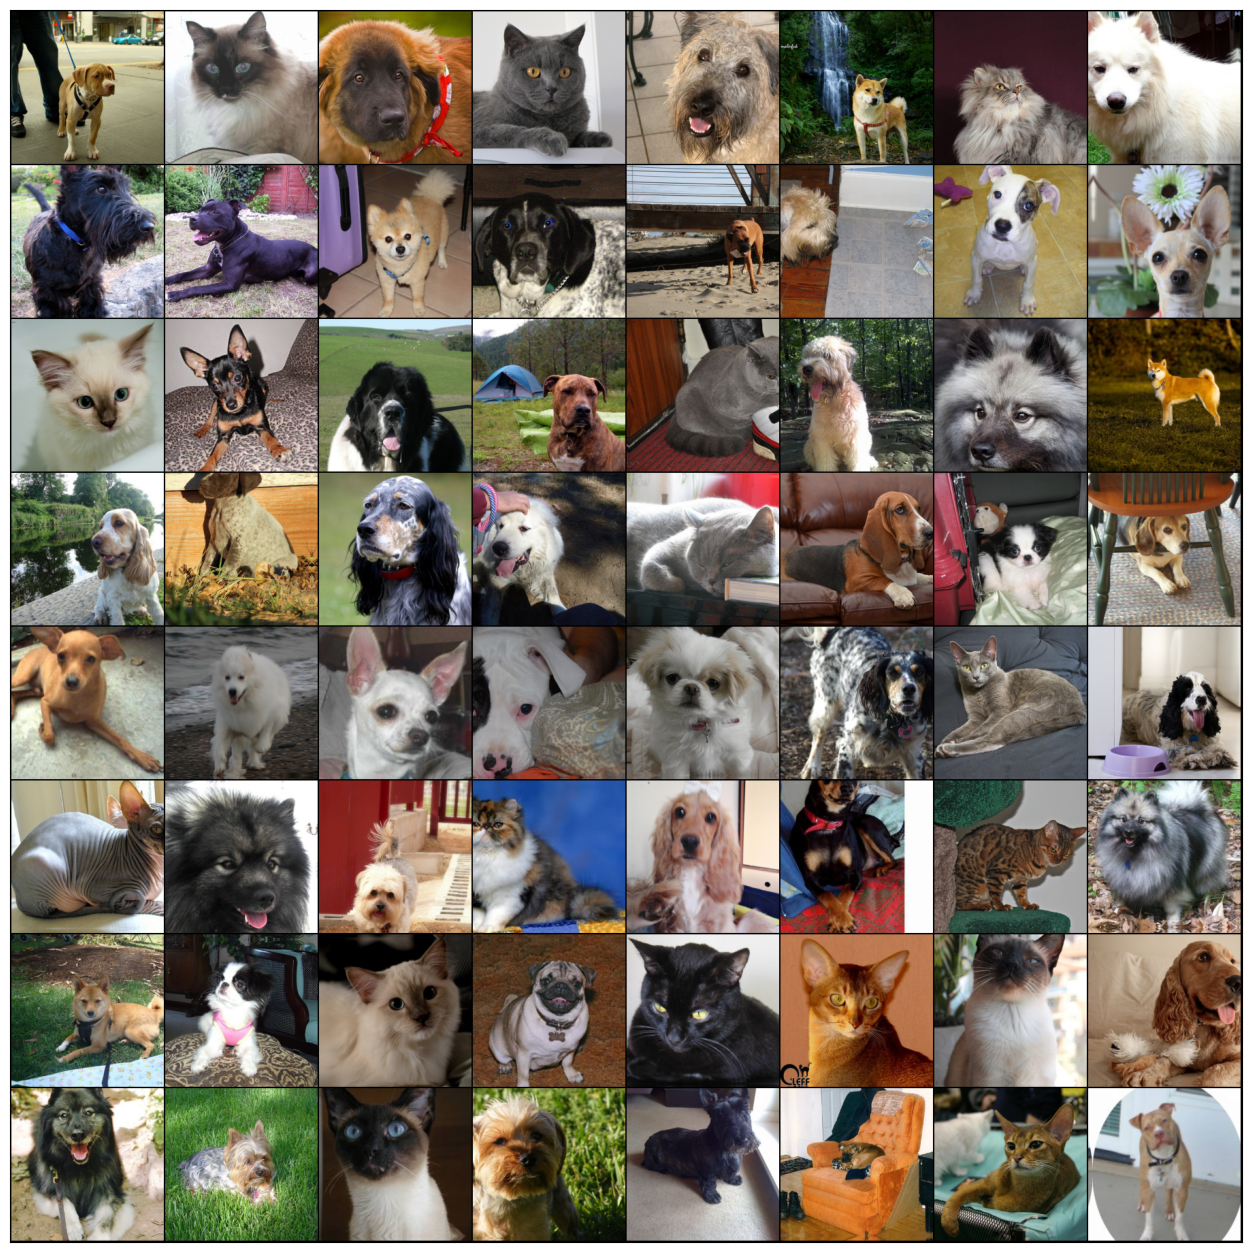

In [34]:
show_batch(train_dl)

# Modifying the pretrained models

ResNet-34 is a 34-layer deep convolutional neural network (CNN) architecture from the Residual Network (ResNet) family, introduced in 2015 to address the degradation problem in very deep networks

In [45]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
  def training_step(self,batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss


  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss': loss.detach(), 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch,result):
    print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}")

In [36]:
from torchvision import models

class PetsModel(ImageClassificationBase):
  def __init__(self,num_classes, pretrained=True):
    super().__init__()
    self.network = models.resnet34(pretrained=pretrained)
    # replace last layer
    self.network.fc = nn.Linear(self.network.fc.in_features,num_classes)

  def forward(self, xb):
    return self.network(xb)

In [37]:
models.resnet34(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [38]:
# gpu utiles and Training loop

def get_default_device():
  """Pick GPU is available, else cpu"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    """Number of batches"""
    return len(self.dl)



In [39]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in tqdm(val_loader)]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    model.train()
    train_losses = []
    for batch in tqdm(train_loader):
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
  return history

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

In [40]:
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
  torch.cuda.empty_cache()
  history = []

  optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
  for epoch in range(epochs):
    model.train()
    train_losses = []
    lrs = []
    for batch in tqdm(train_loader):
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()

      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)

      optimizer.step()
      optimizer.zero_grad()

      lrs.append(get_lr(optimizer))
      sched.step()

    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    result['lrs'] = lrs
    model.epoch_end(epoch, result)
    history.append(result)
  return history



In [41]:
device = get_default_device()
device

device(type='cuda')

In [42]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [43]:
# Finetuning the pretrained model

model = PetsModel(len(dataset.classes), pretrained=True)
to_device(model, device);

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [46]:
history= [evaluate(model, valid_dl)]
history

  0%|          | 0/2 [00:00<?, ?it/s]

[{'val_loss': 3.9816646575927734, 'val_acc': 0.00806201808154583}]

In [47]:
epochs=6
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [48]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                          grad_clip=grad_clip,
                          weight_decay=weight_decay,
                          opt_func=opt_func)

  0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}
CPU times: user 34.5 s, sys: 23.2 s, total: 57.7 s
Wall time: 4min 46s


In [49]:
# training a model from scratch

model2 = PetsModel(len(dataset.classes), pretrained=False)
to_device(model2, device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


PetsModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [50]:
history2 = [evaluate(model2, valid_dl)]
history2


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[{'val_loss': 43.339561462402344, 'val_acc': 0.00806201808154583}]

In [51]:
%%time
history2 += fit_one_cycle(epochs, max_lr, model2, train_dl, valid_dl,
                          grad_clip=grad_clip,
                          weight_decay=weight_decay,
                          opt_func=opt_func)

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}
CPU times: user 37.2 s, sys: 26.3 s, total: 1min 3s
Wall time: 4min 31s


In [1]:
dir(models)

NameError: name 'models' is not defined